#  Experimento 2 — Explorando o poder do OR-Tools no grafo urbano

Neste segundo experimento, o objetivo não é apenas encontrar um único caminho mais curto, mas sim avaliar decisões em conjunto.

## A pergunta agora muda de forma:

>- Se eu precisar sair de casa e visitar vários pontos do bairro, qual é a melhor rota global?

Esse tipo de pergunta é comum em:

- logística urbana;

- entregas;

- planejamento diário;

- cidades inteligentes.

E é exatamente aqui que o OR-Tools começa a se destacar.

## 🔄 Do “caminho mais curto” para a “melhor decisão”

Com Dijkstra, cada destino precisa ser resolvido separadamente:

- casa → hospital

- casa → mercado

- casa → padaria

Cada solução é ótima isoladamente, mas não existe uma visão global.

Com OR-Tools, o problema é reformulado como:

>Qual conjunto de caminhos minimiza o custo total, respeitando regras?

## 🧩 Novo cenário de teste

Usando o mesmo grafo e o mesmo CSV, o cenário agora é:

- ponto de partida fixo: casa X

- pontos obrigatórios:

    - hospital

    - padaria

    - mercado

- objetivo:

    - visitar todos

    - minimizar a distância total

    - sem repetir caminhos desnecessários

Esse problema já não é mais um simples menor caminho — ele se aproxima de um problema de roteamento.

---

## 🧮 Como o OR-Tools enxerga esse problema

No OR-Tools:

- cada possível ligação do grafo é uma variável binária;

- o solver decide quais ruas usar;

restrições garantem que:

- todos os destinos sejam alcançados;

- a rota seja contínua;

- o custo total seja mínimo.

O caminho final não é escolhido passo a passo, mas sim otimizado como um todo.

## 📊 O que este experimento demonstra


- o OR-Tools não depende de algoritmos clássicos de grafos;

- o mesmo grafo pode representar múltiplos problemas diferentes;

- a biblioteca permite pensar em estratégia, não apenas em distância.

Mesmo com uma base simples (CSV + grafo), já é possível simular:

    - rotas urbanas reais;

    - decisões complexas;

   - cenários próximos de aplicações reais.

# instalação das libs

In [ ]:
!pip install ortools

In [ ]:
! pip install networkx matplotlib

In [ ]:
! pip install pyvis


In [ ]:
! pip install folium


In [ ]:
! pip install plotly

In [ ]:
! pip install nbformat


In [ ]:
! pip install geopy folium geopy folium pandas networkx

In [ ]:
! pip install --upgrade nbformat ipython jupyter


# contrução

In [2]:
import pandas as pd
from ortools.sat.python import cp_model


## import of data

In [54]:
csv_path = "data_cajuru.csv"  # ajuste se necessário
df = pd.read_csv(csv_path, index_col=0)

distance_matrix = df.apply(pd.to_numeric, errors="coerce").fillna(0).values
num_nodes = len(distance_matrix)

print(f"Número de nós: {num_nodes}")


Número de nós: 76


## visualization for data

### NetworkX 
NetworkX é uma biblioteca Python para criação e análise de grafos.
No projeto, ela é usada para transformar o CSV em um grafo, onde:

- nós representam ruas ou cruzamentos;

- arestas representam conexões;

- pesos representam distâncias.

> Também é com o NetworkX que calculamos o caminho mais curto (Dijkstra) entre a casa e serviços como padaria, mercado e hospital.

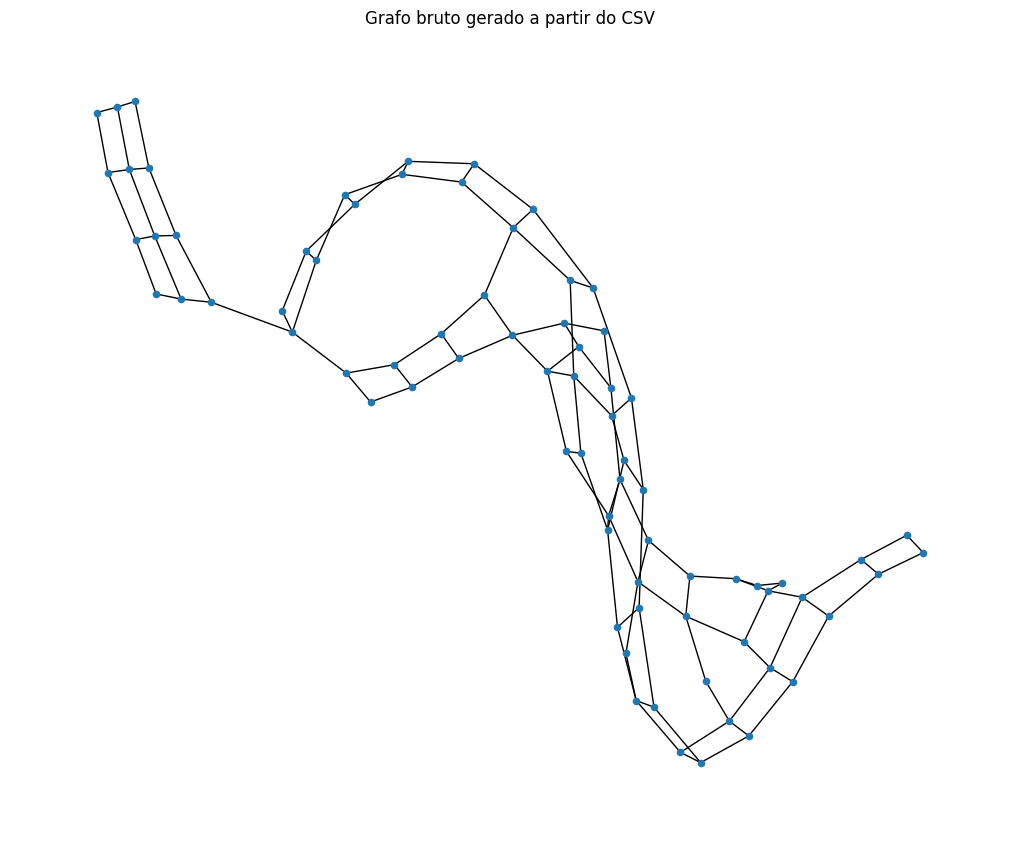

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            G.add_edge(i, j, weight=distance_matrix[i][j])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, with_labels=False)
plt.title("Grafo bruto gerado a partir do CSV")
plt.show()


### PyVis 
PyVis é uma biblioteca para visualização interativa de grafos em HTML.
Ela permite explorar o grafo com zoom e arrastar nós no navegador.

No projeto, o PyVis é usado para visualizar a estrutura do grafo, mas não representa localização real.
É ideal para entender conectividade e relações entre os nós.

In [33]:
from pyvis.network import Network
import pandas as pd

# Garantir matriz numérica limpa
distance_matrix = (
    pd.DataFrame(distance_matrix)
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .values
)

num_nodes = len(distance_matrix)

net = Network(
    height="750px",
    width="100%",
    bgcolor="#0d1117",
    font_color="white",
    notebook=False
)

# Adicionar nós
for i in range(num_nodes):
    net.add_node(
        int(i),
        label=str(i),
        title=f"Nó {i}"
    )

# Adicionar arestas (sem duplicar)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if distance_matrix[i][j] > 0:
            dist = int(distance_matrix[i][j])  # 🔴 CONVERSÃO CRÍTICA

            net.add_edge(
                int(i),
                int(j),
                value=dist,
                title=f"{dist} metros",
                color="#6aa6ff"
            )

# Física ligada para efeito futurista
net.toggle_physics(True)

# Gerar HTML
net.write_html(
    "grafo_cajuru_futurista.html",
    open_browser=True
)

print("✔ Arquivo gerado com sucesso: grafo_cajuru_futurista.html")


✔ Arquivo gerado com sucesso: grafo_cajuru_futurista.html


### Folium + Geopy (Nominatim)

Folium cria mapas interativos reais usando OpenStreetMap.
Geopy (com Nominatim) converte endereços reais em coordenadas geográficas.

No projeto, essa combinação permite:

- usar endereços reais do bairro Cajuru;

- plotar a casa, ruas e serviços no mapa;

- visualizar caminhos mínimos sobre o mapa real.

dicionario

In [47]:
addresses = {
    # 🔴 ponto central (sua casa)
    "Casa": "Rua Engenheiro Ney Tourinho, 70, Cajuru, Curitiba, PR, Brazil",

    # Ruas principais
    "Engenheiro Ney Tourinho": "Rua Engenheiro Ney Tourinho, Cajuru, Curitiba, PR, Brazil",
    "Rubens Thome Speltz": "Rua Rubens Thomé Speltz, Cajuru, Curitiba, PR, Brazil",
    "Roberto Brandini": "Rua Roberto Brandini, Cajuru, Curitiba, PR, Brazil",
    "Leonardo Gelinski": "Rua Leonardo Gelinski, Cajuru, Curitiba, PR, Brazil",
    "Alceu Jose Guadagni": "Rua Alceu José Guadagni, Cajuru, Curitiba, PR, Brazil",
    "Darci Ancay de Freitas": "Rua Darci Ancay de Freitas, Cajuru, Curitiba, PR, Brazil",

    # Eixos estruturais
    "Rua dos Ferroviarios": "Rua dos Ferroviários, Cajuru, Curitiba, PR, Brazil",
    "Humberto Giraldi": "Rua Humberto Giraldi, Cajuru, Curitiba, PR, Brazil",
    "Alberto Gesser": "Rua Alberto Gesser, Cajuru, Curitiba, PR, Brazil",

    # Conectores
    "Roraima": "Rua Roraima, Cajuru, Curitiba, PR, Brazil",
    "Fortaleza": "Rua Fortaleza, Cajuru, Curitiba, PR, Brazil",
    "Terezina": "Rua Terezina, Cajuru, Curitiba, PR, Brazil",
    "Maceio": "Rua Maceió, Cajuru, Curitiba, PR, Brazil",

    # Ruas locais
    "Adalberto Tadeu Vorobi": "Rua Adalberto Tadeu Vorobi, Cajuru, Curitiba, PR, Brazil",
    "Wenceslau Teixeira Alves": "Rua Wenceslau Teixeira Alves, Cajuru, Curitiba, PR, Brazil",
    "Professor David Jorge Curi": "Rua Professor David Jorge Curi, Cajuru, Curitiba, PR, Brazil",
    "Dr Urbano Toniolo": "Rua Doutor Urbano Toniolo, Cajuru, Curitiba, PR, Brazil",
    "Mae Menininha do Gantois": "Rua Mãe Menininha do Gantois, Cajuru, Curitiba, PR, Brazil",
    "Carmen da Silva": "Rua Carmen da Silva, Cajuru, Curitiba, PR, Brazil",
    "Luiz Bertolini": "Rua Luiz Bertolini, Cajuru, Curitiba, PR, Brazil",
    "Darcy Ribeiro": "Rua Darcy Ribeiro, Cajuru, Curitiba, PR, Brazil",

    # Trindade (nome correto)
    "Rua da Trindade": "Rua da Trindade, Cajuru, Curitiba, PR, Brazil",

    # Demais
    "Santa Mariana": "Rua Santa Mariana, Cajuru, Curitiba, PR, Brazil",
    "Dante Melara": "Rua Dante Melara, Cajuru, Curitiba, PR, Brazil",
    "Cidade de Montero": "Rua Cidade de Montero, Cajuru, Curitiba, PR, Brazil",
    "Geraldo Moreira de Macedo": "Rua Geraldo Moreira de Macedo, Cajuru, Curitiba, PR, Brazil",
    "Cuiaba": "Rua Cuiabá, Cajuru, Curitiba, PR, Brazil",
    "Pedro Bellon": "Rua Pedro Bellon, Cajuru, Curitiba, PR, Brazil",
    "Ariovaldo Kato": "Rua Ariovaldo Kato, Cajuru, Curitiba, PR, Brazil",
    "Esper Jorge Chueri": "Rua Esper Jorge Chueri, Cajuru, Curitiba, PR, Brazil",
    "Arlindo Rocha": "Rua Arlindo Rocha, Cajuru, Curitiba, PR, Brazil",
    "Natal": "Rua Natal, Cajuru, Curitiba, PR, Brazil",
    "Ariosvaldo Moreira": "Rua Ariosvaldo Moreira, Cajuru, Curitiba, PR, Brazil",
    "Francisco Walesko": "Rua Francisco Walesko, Cajuru, Curitiba, PR, Brazil"
}


Geocodificação REAL (Nominatim / OpenStreetMap)

In [48]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="graph-routing-optimization")

coords = {}

for name, address in addresses.items():
    try:
        location = geolocator.geocode(address)
        if location:
            coords[name] = (location.latitude, location.longitude)
            print(f"OK → {name}: {coords[name]}")
        else:
            print(f"⚠️ Não encontrado: {name}")
        time.sleep(1)  # respeita o servidor OSM
    except Exception as e:
        print(f"❌ Erro em {name}: {e}")


OK → Casa: (-25.4500755, -49.200245)
OK → Engenheiro Ney Tourinho: (-25.4500755, -49.200245)
OK → Rubens Thome Speltz: (-25.4508198, -49.2003785)
OK → Roberto Brandini: (-25.4502732, -49.1999407)
OK → Leonardo Gelinski: (-25.4451863, -49.2007784)
⚠️ Não encontrado: Alceu Jose Guadagni
OK → Darci Ancay de Freitas: (-25.4514969, -49.1996472)
OK → Rua dos Ferroviarios: (-25.4527044, -49.2146497)
OK → Humberto Giraldi: (-25.4486443, -49.2070929)
OK → Alberto Gesser: (-25.448735, -49.2017847)
OK → Roraima: (-25.4522885, -49.2077553)
OK → Fortaleza: (-25.4496912, -49.2082753)
⚠️ Não encontrado: Terezina
OK → Maceio: (-25.4508651, -49.2115844)
OK → Adalberto Tadeu Vorobi: (-25.4439395, -49.2041837)
OK → Wenceslau Teixeira Alves: (-25.4467617, -49.2037203)
OK → Professor David Jorge Curi: (-25.446937, -49.2042906)
OK → Dr Urbano Toniolo: (-25.4464725, -49.205096)
OK → Mae Menininha do Gantois: (-25.4498399, -49.2029869)
OK → Carmen da Silva: (-25.4504237, -49.2032678)
OK → Luiz Bertolini: (-25

Mapa REAL com Folium

In [53]:
import folium

# centro do mapa = sua casa
home_lat, home_lon = coords["Casa"]

m = folium.Map(location=[home_lat, home_lon], zoom_start=16, tiles="cartodb dark_matter")

# marcadores
for name, (lat, lon) in coords.items():
    color = "red" if name == "Casa" else "cyan"
    folium.CircleMarker(
        location=[lat, lon],
        radius=6 if name == "Casa" else 4,
        popup=name,
        color=color,
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

m


Conectando com CSV (grafo urbano real)

In [50]:
import pandas as pd
import networkx as nx

df = pd.read_csv("data_cajuru.csv", index_col=0)
G = nx.Graph()

# adiciona nós com coordenadas reais
for node in coords:
    G.add_node(node, pos=coords[node])

# exemplo de ligação manual (depois automatiza)
G.add_edge("Casa", "Engenheiro Ney Tourinho", weight=50)
G.add_edge("Engenheiro Ney Tourinho", "Rubens Thome Speltz", weight=57)


Desenhar rotas REAIS no mapa

In [51]:
path = nx.dijkstra_path(G, source="Casa", target="Rubens Thome Speltz", weight="weight")

for i in range(len(path) - 1):
    p1 = coords[path[i]]
    p2 = coords[path[i + 1]]
    folium.PolyLine(
        locations=[p1, p2],
        color="lime",
        weight=4
    ).add_to(m)

m


### Plotly 
Plotly é uma biblioteca de visualização interativa.
Aqui, ela é usada para mostrar o grafo de forma visual e explorável, com hover e zoom.

Assim como o PyVis, o Plotly mostra a estrutura do grafo, não a geografia real, sendo útil para análise e apresentação.

In [52]:
import plotly.graph_objects as go
import plotly.io as pio
import networkx as nx
import pandas as pd

pio.renderers.default = "browser"  # 🔥 CORREÇÃO DEFINITIVA

distance_matrix = df.apply(pd.to_numeric, errors="coerce").fillna(0).values
num_nodes = len(distance_matrix)

G = nx.Graph()

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if distance_matrix[i][j] > 0:
            G.add_edge(i, j)

print("Nós:", G.number_of_nodes())
print("Arestas:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42)

edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x, node_y, node_text = [], [], []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"Nó {node}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=0.5, color="gray"),
    hoverinfo="none"
))

fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    marker=dict(size=6, color="cyan"),
    hoverinfo="text",
    text=node_text
))

fig.update_layout(
    title="Visualização interativa do grafo urbano",
    showlegend=False,
    plot_bgcolor="black",
    paper_bgcolor="black",
    font_color="white"
)

fig.show()


Nós: 76
Arestas: 116


## Definição do cenário

In [55]:
# Nó da casa
source = 0

# Pontos de interesse (exemplo)
hospital = 45
padaria = 6
mercado = 15

targets = [hospital, padaria, mercado]


### Criar o modelo de otimização (OR-Tools)

Aqui está a diferença conceitual:

- cada aresta possível vira uma variável de decisão  o solver escolhe quais caminhos usar

In [56]:
model = cp_model.CpModel()

# Variáveis: x[i,j] = 1 se a aresta i -> j for usada
x = {}

for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            x[(i, j)] = model.NewBoolVar(f"x_{i}_{j}")


### Restrições de fluxo (conceito de grafo)

Essas restrições garantem:

- saída da origem

- chegada no destino

- continuidade do caminho

In [57]:
for node in range(num_nodes):
    incoming = []
    outgoing = []

    for i in range(num_nodes):
        if (i, node) in x:
            incoming.append(x[(i, node)])
    for j in range(num_nodes):
        if (node, j) in x:
            outgoing.append(x[(node, j)])

    if node == source:
        # Sai da casa exatamente uma vez
        model.Add(sum(outgoing) - sum(incoming) == 1)

    elif node in targets:
        # Cada destino deve ser visitado pelo menos uma vez
        model.Add(sum(incoming) >= 1)

    else:
        # Continuidade do caminho
        model.Add(sum(incoming) == sum(outgoing))


### Função objetivo (minimizar distância total)

In [58]:
model.Minimize(
    sum(distance_matrix[i][j] * x[(i, j)] for (i, j) in x)
)


### Resolver o modelo

In [59]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 15

status = solver.Solve(model)

print("Status:", solver.StatusName(status))


Status: OPTIMAL


### Extração da rota encontrada

In [60]:
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):

    print("\nRota otimizada encontrada:\n")

    # Reconstrução da rota
    current = source
    path = [current]
    visited_targets = set()
    total_distance = 0

    while len(visited_targets) < len(targets):
        moved = False
        for j in range(num_nodes):
            if (current, j) in x and solver.Value(x[(current, j)]) == 1:
                total_distance += distance_matrix[current][j]
                current = j
                path.append(current)

                if current in targets:
                    visited_targets.add(current)

                moved = True
                break

        if not moved:
            break

    print(" → ".join(map(str, path)))
    print(f"\nDistância total: {total_distance} metros")
    print("Destinos visitados:", visited_targets)

else:
    print("Nenhuma solução encontrada.")



Rota otimizada encontrada:

0 → 1 → 6

Distância total: 217 metros
Destinos visitados: {6}


### visualização do resultado

In [61]:
import folium
from geopy.geocoders import Nominatim
import time


#### dicionario de nos  -> endereço real 

In [ ]:
# ==============================
# Nós do grafo → endereços reais
# ==============================

node_addresses = {
    # Casa (ponto de partida)
    0: "Rua Engenheiro Ney Tourinho, 70, Cajuru, Curitiba, PR, Brazil",

    # Pontos de interesse
    6: "Rua Darci Ancay de Freitas, Cajuru, Curitiba, PR, Brazil",   # Padaria
    15: "Rua Terezina, Cajuru, Curitiba, PR, Brazil",               # Mercado
    45: "Rua Fortaleza, Cajuru, Curitiba, PR, Brazil",              # Hospital / UPA
}


#### Geocodificação (endereços → coordenadas)

In [63]:
geolocator = Nominatim(user_agent="graph-routing-lab")

coords = {}

for node, address in node_addresses.items():
    try:
        location = geolocator.geocode(address)
        if location:
            coords[node] = (location.latitude, location.longitude)
            print(f"Nó {node} geocodificado")
        time.sleep(1)  # evita bloqueio
    except:
        print(f"Erro no nó {node}")


Nó 0 geocodificado
Nó 6 geocodificado
Nó 45 geocodificado


#### Caminho encontrado pelo OR-Tools

In [64]:
path


[0, 1, 6]

#### Criar mapa Folium

In [66]:
start_lat, start_lon = coords[source]

m = folium.Map(
    location=[start_lat, start_lon],
    zoom_start=15,
    tiles="CartoDB dark_matter"
)


#### Plotar nós importantes 

In [67]:
for node, (lat, lon) in coords.items():
    if node == source:
        color = "green"
        label = "Casa"
    elif node in targets:
        color = "red"
        label = f"Destino ({node})"
    else:
        color = "blue"
        label = f"Nó {node}"

    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        popup=label,
        color=color,
        fill=True
    ).add_to(m)


#### Desenhar a rota

In [68]:
route_coords = []

for node in path:
    if node in coords:
        route_coords.append(coords[node])

folium.PolyLine(
    locations=route_coords,
    color="cyan",
    weight=4,
    opacity=0.8
).add_to(m)


In [69]:
m
